In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'
geometry = None # [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='BK')
### HAMILTONIAN end

#####################################

QubitHamiltonian

(-0.32760818995565577+0j) [] +
(0.04919764587885283+0j) [X0 Z1 X2] +
(0.04919764587885283+0j) [X0 Z1 X2 Z3] +
(0.04919764587885283+0j) [Y0 Z1 Y2] +
(0.04919764587885283+0j) [Y0 Z1 Y2 Z3] +
(0.1371657293179602+0j) [Z0] +
(0.1371657293179602+0j) [Z0 Z1] +
(0.15542669076236065+0j) [Z0 Z1 Z2] +
(0.15542669076236065+0j) [Z0 Z1 Z2 Z3] +
(0.10622904488350779+0j) [Z0 Z2] +
(0.10622904488350779+0j) [Z0 Z2 Z3] +
(0.15660062486143395+0j) [Z1] +
(-0.13036292044009176+0j) [Z1 Z2 Z3] +
(0.1632676867167479+0j) [Z1 Z3] +
(-0.13036292044009176+0j) [Z2]

In [2]:
from quchem.Ansatz_Generator_Functions import *


ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)



Sec_Quant_CC_ops_ia, Sec_Quant_CC_ops_ijab, theta_parameters_ia, theta_parameters_ijab=ansatz_obj.Get_ia_and_ijab_terms(single_cc_amplitudes=None, 
                                                                                                             double_cc_amplitudes=None, 
                                                                                                             singles_hamiltonian=None,
                                                                                                             doubles_hamiltonian=None, 
                                                                                                             tol_filter_small_terms = None)

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ops_ia,
                                                                                                                    Sec_Quant_CC_ops_ijab,
                                                                                                                   transformation='BK')
full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, 
                                                              theta_parameters_ijab,
                                                              transformation='BK')

# print(ansatz_cirq_circuit.to_text_diagram(transpose=True)) 

LOOK at:

PHYS. REV. X, **8**, 031022 (2018)

In [3]:
new_BK = BK_Qubit_Reordering(
                QubitHamiltonian,
                 Qubit_Op_list_Second_Quant_CC_Ops_ia,
                 Qubit_Op_list_Second_Quant_CC_Ops_ijab,
                 Hamilt.molecule.n_qubits,
                ansatz_obj.Get_BK_HF_state_in_OCC_basis(),
                Hamilt.molecule.n_electrons)

NEW_Qubit_Molecular_Hamiltonian = new_BK.Get_Reordered_Hamiltonian_2_qubits_removed()
NEW_Qubit_Molecular_Hamiltonian

(-0.007739878377473919+0j) [] +
(0.09839529175770566+0j) [X0 X1] +
(0.09839529175770566+0j) [Y0 Y1] +
(0.2743314586359204+0j) [Z0] +
(0.5233114712917368+0j) [Z0 Z1] +
(-0.2607258408801835+0j) [Z1]

In [4]:
NEW_ijab_terms = new_BK.Get_Reordered_CC_qubit_terms_2_qubits_removed() #ijab terms!
NEW_ijab_terms

[0.5j [X0 Y1] +
 -0.5j [Y0 X1]]

## Ansatz

In [ ]:
-1j*-1j


From PHYS. REV. X, **8**, 031022 (2018):

$$U = e^{-i \theta Y_{0} X_{1}}$$

- when acting on $| 01 \rangle_{HF-BK-STATE}$ 

$$U | \psi_{HF}\rangle = | \psi_{UCCSD}\rangle$$

overall we get:

$\begin{aligned} U|01\rangle &=\left(\cos (\theta) I-i \sin (\theta) Y_{0} X_{1}\right)|10\rangle \\ &=\cos (\theta)|10\rangle-\sin (\theta)|11\rangle \end{aligned}$

- note $Y|1\rangle = -i|1\rangle$

to do this in Q.C the following circuit is employed:

In [5]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz_BK(theta):
    
    HF_circ = [cirq.X.on(cirq.LineQubit(0))]
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1', -1j), theta)
        
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
circuit_form = H2_ansatz_BK(np.pi/10)    
circuit_form

0: ───X───Rx(0.5π)───@──────────────@───Rx(-0.5π)───
                     │              │
1: ───H──────────────X───Rz(0.2π)───X───H───────────

In [ ]:
from quchem.Simulating_Quantum_Circuit import *

In [10]:
n_shots= 10000


def VQE_experiment_ENERGY(THETA):
    ansatz_cirq_circuit = H2_ansatz_BK(THETA)
    VQE_exp = VQE_Experiment(NEW_Qubit_Molecular_Hamiltonian, ansatz_cirq_circuit, n_shots)
    return VQE_exp.Calc_Energy().real

In [11]:
theta_val = np.pi

VQE_experiment_ENERGY(theta_val)

-1.0689424335879365

In [12]:
import random

theta_random_input = random.uniform(0, 2*np.pi) 

0: Input_to_Funct: [3.92711139]: Output: -0.7227906255807615
1: Input_to_Funct: [3.49076568]: Output: -1.0693956350062188
2: Input_to_Funct: [3.27259283]: Output: -1.097274226069493
3: Input_to_Funct: [3.27259283]: Output: -1.0994670210654918
4: Input_to_Funct: [3.32713604]: Output: -1.1018196666239275
5: Input_to_Funct: [3.32713604]: Output: -1.100381901752813
6: Input_to_Funct: [3.32713604]: Output: -1.102956689114011
7: Input_to_Funct: [3.32031814]: Output: -1.1013256187878377
8: Input_to_Funct: [3.32372709]: Output: -1.0990899851848681
9: Input_to_Funct: [3.32713604]: Output: -1.104564225643698
10: Input_to_Funct: [3.32713604]: Output: -1.0999974945336968
11: Input_to_Funct: [3.32713604]: Output: -1.101790553130738
12: Input_to_Funct: [3.32713604]: Output: -1.10112763429328
13: Input_to_Funct: [3.32756216]: Output: -1.103815328458566
14: Input_to_Funct: [3.32756216]: Output: -1.1008598516644967
15: Input_to_Funct: [3.32756216]: Output: -1.1029299445905587
16: Input_to_Funct: [3.327

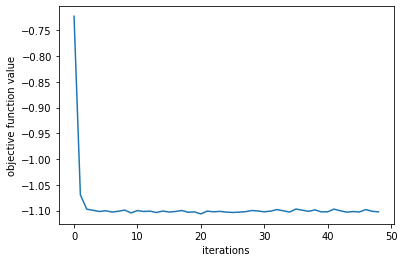

In [13]:
### optimizer
from quchem.Scipy_Optimizer import *

GG = Optimizer(VQE_experiment_ENERGY, theta_random_input, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

In [14]:
Hamilt.molecule.fci_energy

array(-1.10115033)

In [26]:
from quchem.TensorFlow_Opt import *

**gradient is given by**

https://arxiv.org/pdf/1906.08728.pdf

$$\frac{\partial O(\theta)}{\partial \theta}=\left\langle\overrightarrow{0}\left|\hat{U}^{\dagger} \hat{R}_{y}^{C \dagger}(\theta+\pi / 4) \hat{V}^{\dagger} \hat{O} \hat{V} \hat{R}_{y}^{C}(\theta+\pi / 4) \hat{U}\right| \overrightarrow{0}\right\rangle -\left\langle\overrightarrow{0}\left|\hat{U}^{\dagger} \hat{R}_{y}^{C \dagger}(\theta-\pi / 4) \hat{V}^{\dagger} \hat{O} \hat{V} \hat{R}_{y}^{C}(\theta-\pi / 4) \hat{U}\right| \overrightarrow{0}\right\rangle$$

$$\frac{\partial O(\theta)}{\partial \theta} =O(\theta+\pi / 4)-O(\theta-\pi / 4)$$

In [33]:
def VQE_experiment_ENERGY_TF(THETA):
    ansatz_cirq_circuit = H2_ansatz_BK(THETA[0])
    VQE_exp = VQE_Experiment(NEW_Qubit_Molecular_Hamiltonian, ansatz_cirq_circuit, n_shots)
    return VQE_exp.Calc_Energy().real

In [27]:
def calc_gradient_TF(THETA):      

    Obs_PLUS = VQE_experiment_ENERGY(THETA[0] + np.pi/4)
    Obs_MINUS = VQE_experiment_ENERGY(THETA[0] - np.pi/4)
    
    gradient = Obs_PLUS - Obs_MINUS
        
    return [(gradient, theta)]

note:
this is very SLOW as it has to run a separate experiment TWICE for each parameter before taking a step!

In [34]:
X0 = [random.uniform(0, 2*np.pi)]

tf_opt = Tensor_Flow_Optimizer(VQE_experiment_ENERGY_TF, X0, 'Adam', calc_gradient_TF, learning_rate=0.1, beta1=0.9,
                            beta2=0.999, store_values=True, display_iter_steps=True)
tf_opt.optimize(50)
tf_opt.plot_convergence()

starting input: [3.836605558845308] obj funct out: -0.8221815646786668


TypeError: can only concatenate list (not "float") to list

In [18]:
from quchem.Adam_Optimizer import *

In [20]:
def calc_gradient_ADAM(THETA):      

    Obs_PLUS = VQE_experiment_ENERGY(THETA + np.pi/4)
    Obs_MINUS = VQE_experiment_ENERGY(THETA - np.pi/4)
    
    gradient = Obs_PLUS - Obs_MINUS
        
    return gradient

In [22]:
X0 = random.uniform(0, 2*np.pi)

opt_params, list_of_inputs, list_of_outputs = Adam_Opt(X0, VQE_experiment_ENERGY,
                                                       calc_gradient_ADAM, 
                                                       learning_rate=0.01, 
                                                       beta_1=0.9, 
                                                       beta_2=0.999, 
                                                       epsilon=1e-8,
                                                       max_iter=50,
                                                       disp=True,
                                                       tolerance=1e-3,
                                                       store_steps=True)

VQE_experiment_ENERGY(opt_params)

step: 1 input:1.5019773776656529 obj_funct: -0.029795112892471
step: 2 input:1.4919681094498642 obj_funct: -0.03157702590920336
step: 3 input:1.4819469279785955 obj_funct: -0.04039026677881813
step: 4 input:1.4719064479300166 obj_funct: -0.0476788681110385
step: 5 input:1.4618486508247939 obj_funct: -0.05276297542578079
step: 6 input:1.451763049919435 obj_funct: -0.057933244421978225
step: 7 input:1.4416451117726856 obj_funct: -0.06319708867953677
step: 8 input:1.4314900301116842 obj_funct: -0.07003056978705285
step: 9 input:1.4212933678075048 obj_funct: -0.07849677256746568
step: 10 input:1.4110569372728228 obj_funct: -0.08378192373956306
step: 11 input:1.4007852561906138 obj_funct: -0.09290206342049734
step: 12 input:1.390471582810515 obj_funct: -0.09990131846189026
step: 13 input:1.3801145029317246 obj_funct: -0.1081926737045995
step: 14 input:1.3697123041363801 obj_funct: -0.1181140431116311
step: 15 input:1.3592627946965503 obj_funct: -0.12739460120845086
step: 16 input:1.34876363

-0.5304054472834554

In [ ]:
import matplotlib.pyplot as plt
# % matplotlib inline
plt.figure()
plt.plot(list_of_outputs)
plt.xlabel('iterations')
plt.ylabel('objective function value')
plt.show()